In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#default_exp search

In [3]:
#export
import sys
sys.path.insert(0,'..')
from mytools.tools import *
from food.paths import *
from food.psql import *
import requests
import torch
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw, ImageEnhance,ImageOps
from food.paths import *
from stego.segment import get_food_segment
from segmentor.segment import *

from mytools.visual import *
from food.depth import *

from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import cv2
import numpy as np
from matplotlib import pyplot as plt

dev
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (UnsupervisedMetrics). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


/home/dima/FoodSeg103-Benchmark-v1/checkpoints/SETR_Naive_ReLeM


/home/dima/FoodSeg103-Benchmark-v1/mmseg/models/builder.py:59: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  warnings.warn(


load pre-trained weight from imagenet21k


In [4]:
#export
def apply_custom_colormap(image_gray, cmap):

    assert image_gray.dtype == np.uint8, 'must be np.uint8 image'

    # Initialize the matplotlib color map
    sm = plt.cm.ScalarMappable(cmap=cmap)

    # Obtain linear color range
    color_range = sm.to_rgba(np.linspace(0, 1, 256))[:,0:3]    # color range RGBA => RGB
    color_range = (color_range*255.0).astype(np.uint8)         # [0,1] => [0,255]
    # color_range = np.squeeze(np.dstack([color_range[:,2], color_range[:,1], color_range[:,0]]), 0)  # RGB => BGR

    # Apply colormap for each channel individually
    channels = [cv2.LUT(image_gray, color_range[:,i]) for i in range(3)]
    return np.dstack(channels)

In [5]:
#export
def get_heatmap(arr,
                colors = ["white","lime","green","yellow","orange", "red","purple","purple","purple","purple","purple","purple"],
                values = [0,           1,     50,     100,     200,   300,     400,     500,     600,     700,     800,     900]):
    
    l = list(zip([v/max(values) for v in values],colors))
    cmap=LinearSegmentedColormap.from_list('hmap',l)
    return apply_custom_colormap((np.array(arr)/max(values)*255).astype(np.uint8),cmap)
    

In [6]:
#export
def blend_array2img(img,arr,alphas = [0.5,0.5]):
    return cv2.addWeighted(arr, alphas[0], np.array(img).astype(np.uint8), alphas[1], 0)

In [7]:
#export
bad_cats  = ['Vegetables on a sandwich','Candy containing chocolate','Baby juice']
bad_descs = ['Banana, fried']
bad_keys = ['baby food','frozen','juice','drink']
bad_keys_cat = ['formula']


foods = pd.read_sql("""select f.*
                        from food.foods_prompted f""",engine)

# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')
foods = foods.dropna()

foods = foods[~foods['category'].isin(bad_cats)]
foods = foods[~foods['description'].isin(bad_descs)]
foods = foods[~foods['description'].str.contains('|'.join(bad_keys))]
foods = foods[~foods['category']   .str.lower().str.contains('|'.join(bad_keys_cat))]

food_clips = series2tensor(foods['clip'])

/home/dima/mytools/mytools/visual.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])


In [8]:
#export
def search(url,prompt_factor=0.5,min_score=0.22,exand_times =2):
    img = get_image_from_url(url)
    img,adj = crop_image_to_square(img,True)
    x_adj,y_adj,size = adj
    photo_id = url.split('/')[-1]
    i = np.asarray(img, dtype="uint8")
    i = np.flip(i,2)
    segmentor_mask = inference_segmentor(segment_model, i)[0]
    segmentor_mask[segmentor_mask!=0]=segmentor_mask[segmentor_mask!=0]+1 



    classes = np.unique(segmentor_mask)[1:]
    classes_ =[]
    urls = []
    for c in classes:
        area = segmentor_mask[segmentor_mask==c].shape[0]
        if area> 20*20:
            class_mask = np.where(segmentor_mask==c,1,0)
            class_mask = expand_boundaries(class_mask,times=exand_times,factor=10)
            img_arr = apply_mask(img,class_mask.T).astype(np.uint8)
            img_arr = crop_zeros(img_arr)
            img_arr[img_arr==[0,0,0]]=255 #replace black with while
            fname = f'{photo_id}_{c}.jpg'
            Image.fromarray(img_arr).save(fragment_reference_images_path/fname)
            urls.append(f'https://dima.grankin.eu/fragment_reference_images/{fname}')
            classes_.append(c)
    classes = classes_

    stego_img,stego_mask = get_food_segment(img)

    s = np.copy(segmentor_mask)
    s[s!=0] = 1
    inverse_stego_mask = stego_mask - s
    inverse_stego_mask[inverse_stego_mask==-1]=0
    inverse_stego_img = Image.fromarray(apply_mask(img,inverse_stego_mask).astype(np.uint8))
    ##new
    stego_img        .save(fragment_reference_images_path/f'{photo_id}_stego.jpg')
    inverse_stego_img.save(fragment_reference_images_path/f'{photo_id}_inverse_stego.jpg')
    urls.append(f'https://dima.grankin.eu/fragment_reference_images/{photo_id}_inverse_stego.jpg')

    #to push segmented clips towards the whole dish clip
    main_image_clip = get_image_clip(f'https://dima.grankin.eu/fragment_reference_images/{photo_id}_stego.jpg')

    clip_df = pd.DataFrame()
    for u in urls:
        df = search_clip(u,foods,food_clips,prompt_clip=main_image_clip,head = 1,prompt_factor=prompt_factor)[1]
        # df['url'] = u
        clip_df = clip_df.append(df)
    clip_df=clip_df.reset_index(drop=True)
    clip_df['classes'] = classes+[1]
    #new

    clip_df=clip_df[clip_df['score']>min_score]

    mask = inverse_stego_mask+segmentor_mask

    dicts =[]
    masks =[]

    attributes = ['energy','protein','carb','fat']
    #create masks of attributes
    for col in attributes:
        dicts.append(clip_df[['classes',col]].set_index("classes")[col].to_dict())
        masks.append(torch.clone(mask))

    areas = {}
    for c in np.unique(mask):
        areas[c]= mask[mask==c].shape[0]

        #clean values where classes are filtered out
        if c not in dicts[0].keys():
            for m in masks:
                m[m==c]=0

    #areas          
    clip_df = clip_df.merge(pd.DataFrame(areas,index = ['area']).T,left_on = 'classes',right_index = True)
    clip_df = clip_df.sort_values('area',ascending = False)

    #assign values to the masks
    for d,m in zip(dicts,masks):
        for k,v in d.items(): m[m == k] = v

    stats = pd.DataFrame([float(m[m!=0].mean()) for m in masks]+[masks[0][masks[0]!=0].shape[0]],
                     index = attributes+['size'])


    img = ImageOps.grayscale(img).convert('RGB')
    blended_img = blend_array2img(img,get_heatmap(masks[0]),alphas=[0.5, 0.9])
    img = Image.fromarray(blended_img[-y_adj:size+y_adj,-x_adj:size+x_adj,:])
    return img,clip_df,masks,urls,stats

In [9]:
df = pd.read_sql('select * from food.dishes',engine)
photo_ids = df[df['user_id']==78882798]['photo_id'].drop_duplicates().tolist()

In [10]:
photo_id = photo_ids[-2]
url = f'https://dima.grankin.eu/reference_images/{photo_id}'

In [11]:
exand_times = 5

In [12]:
img = get_image_from_url(url)
img,adj = crop_image_to_square(img,True)
x_adj,y_adj,size = adj
photo_id = url.split('/')[-1]
i = np.asarray(img, dtype="uint8")
i = np.flip(i,2)
segmentor_mask = inference_segmentor(segment_model, i)[0]
segmentor_mask[segmentor_mask!=0]=segmentor_mask[segmentor_mask!=0]+1 



classes = np.unique(segmentor_mask)[1:]
classes_ =[]
urls = []
for c in classes:
    area = segmentor_mask[segmentor_mask==c].shape[0]
    if area> 20*20:
        class_mask = np.where(segmentor_mask==c,1,0)
        class_mask = expand_boundaries(class_mask,times=exand_times,factor=10)
        img_arr = apply_mask(img,class_mask.T).astype(np.uint8)
        img_arr = crop_zeros(img_arr)
        img_arr[img_arr==[0,0,0]]=255 #replace black with while
        fname = f'{photo_id}_{c}.jpg'
        Image.fromarray(img_arr).save(fragment_reference_images_path/fname)
        urls.append(f'https://dima.grankin.eu/fragment_reference_images/{fname}')
        classes_.append(c)
classes = classes_

stego_img,stego_mask = get_food_segment(img)

s = np.copy(segmentor_mask)
s[s!=0] = 1
inverse_stego_mask = stego_mask - s
inverse_stego_mask[inverse_stego_mask==-1]=0
inverse_stego_img = Image.fromarray(apply_mask(img,inverse_stego_mask).astype(np.uint8))
##new
stego_img        .save(fragment_reference_images_path/f'{photo_id}_stego.jpg')
inverse_stego_img.save(fragment_reference_images_path/f'{photo_id}_inverse_stego.jpg')
urls.append(f'https://dima.grankin.eu/fragment_reference_images/{photo_id}_inverse_stego.jpg')

#to push segmented clips towards the whole dish clip
main_image_clip = get_image_clip(f'https://dima.grankin.eu/fragment_reference_images/{photo_id}_stego.jpg')

/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/dima/anaconda3/envs/f

In [13]:
prompt_factor = 0.3

In [14]:
probe_size = 10

In [15]:
clip_df = pd.DataFrame()
dfs = []
for i,c in zip(list(range(len(urls))),classes+[1],):
    df = search_clip(urls[i],foods,food_clips,prompt_clip=main_image_clip,head = probe_size,prompt_factor=prompt_factor)[1]
    df['url']   = i
    df['classes']=c
    dfs.append(df)
clip_df = pd.concat(dfs)

In [16]:
clip_df = clip_df[clip_df['score']>0.22]

In [17]:
d = {c:'mean' for c in ['energy','protein','carb','fat','score']}
d['classes'] = 'first'
d['url']     = 'first'

In [18]:
clip_df_agg = clip_df.groupby('url').agg(d).reset_index(drop = True)

In [19]:
mask = inverse_stego_mask+segmentor_mask

dicts =[]
masks =[]

attributes = ['energy','protein','carb','fat']
#create masks of attributes
for col in attributes:
    dicts.append(clip_df_agg[['classes',col]].set_index("classes")[col].to_dict())
    masks.append(torch.clone(mask))

areas = {}
for c in np.unique(mask):
    areas[c]= mask[mask==c].shape[0]/probe_size

    #clean values where classes are filtered out
    if c not in dicts[0].keys():
        for m in masks:
            m[m==c]=0

#areas          
clip_df = clip_df.merge(pd.DataFrame(areas,index = ['area']).T,left_on = 'classes',right_index = True)
clip_df = clip_df.sort_values('area',ascending = False)

#assign values to the masks
for d,m in zip(dicts,masks):
    for k,v in d.items(): m[m == k] = v

stats = pd.DataFrame([float(m[m!=0].mean()) for m in masks]+[masks[0][masks[0]!=0].shape[0]],
                 index = attributes+['size'])


img = ImageOps.grayscale(img).convert('RGB')
blended_img = blend_array2img(img,get_heatmap(masks[0]),alphas=[0.5, 0.9])
img = Image.fromarray(blended_img[-y_adj:size+y_adj,-x_adj:size+x_adj,:])

In [20]:
clip_df_agg

,energy,protein,carb,fat,score,classes,url
0,67.1,2.843,10.264,2.619,0.274747,10,0
1,42.9,2.453,4.857,2.177,0.280707,29,1
2,422.1,13.776,40.389,27.859,0.273559,47,2
3,326.3,9.218,57.836,9.266,0.280016,48,3
4,163.2,7.031,12.475,11.071,0.275020,49,4
5,347.5,10.686,45.083,16.573,0.281451,53,5
6,71.0,3.456,6.939,3.701,0.289194,68,6
7,45.1,2.239,4.921,2.429,0.287553,74,7
8,41.5,2.487,5.601,1.760,0.274594,81,8
9,237.8,3.974,6.000,23.230,0.280157,90,9


In [28]:
clip_df.sort_values('area',ascending = False).drop_duplicates("classes")

,id,description,category,energy,protein,carb,fat,text,clip,score,url,classes,area
1,1103339,"Broccoflower, raw",Other vegetables and combinations,31.0,2.95,6.09,0.30,the food is other vegetables and combinations ...,"[0.046773534, -0.005051376, -0.006337247, 0.01...",0.291160,9,90,4183.9
3,1103160,"Turrnip greens, NS as to form, cooked",Other dark green vegetables,42.0,1.11,4.23,2.76,the food is other dark green vegetables . it h...,"[0.06352928, -0.0053253192, -0.0017851907, -0....",0.288657,7,74,2595.7
4,1100427,"Blackeyed peas, NFS","Beans, peas, legumes",165.0,7.18,19.29,7.00,"the food is beans, peas, legumes . it has a li...","[0.044176396, -0.004219489, 0.042826645, 0.024...",0.228078,10,1,2354.5
7,1101821,"Cereal, puffed wheat, sweetened","Ready-to-eat cereal, higher sugar (>21.2g/100g)",380.0,5.70,88.50,2.20,"the food is ready-to-eat cereal, higher sugar ...","[0.033632766, 0.025471952, -0.00456566, 0.0538...",0.277428,5,53,1998.1
4,1101538,"Buckwheat groats, fat added","Pasta, noodles, cooked grains",112.0,3.22,18.99,3.34,"the food is pasta, noodles, cooked grains . it...","[0.033298783, -0.008431105, 0.022476165, 0.043...",0.279573,3,48,1763.9
8,1103523,"Mushrooms, fresh, cooked, fat added, NS as to ...",Other vegetables and combinations,55.0,3.75,3.95,3.58,the food is other vegetables and combinations ...,"[0.030972261, -0.002906953, 0.009952719, 0.018...",0.270637,4,49,805.9
2,1100612,Chia seeds,Nuts and seeds,534.0,18.29,28.88,42.16,the food is nuts and seeds . it has a little b...,"[0.0029685835, 0.0016799904, 0.008622316, 0.02...",0.273660,2,47,787.6
7,1103123,"Kale, canned, cooked, fat added",Other dark green vegetables,41.0,1.32,2.71,2.81,the food is other dark green vegetables . it h...,"[0.021137089, -0.022269255, 0.015573246, 0.010...",0.276088,1,29,600.6
0,1103104,"Dandelion greens, raw",Other dark green vegetables,45.0,2.70,9.20,0.70,the food is other dark green vegetables . it h...,"[0.04413233, -0.004352971, 0.022287205, 0.0119...",0.283157,8,81,414.1
4,1100758,"Bread, wheat or cracked wheat, reduced calorie...",Yeast breads,228.0,9.79,49.35,2.80,the food is yeast breads . it has a little bit...,"[0.005275675, -0.0058794008, -0.0048363484, 0....",0.271861,0,10,150.8


In [35]:
clip_df[clip_df['url']==5]

,id,description,category,energy,protein,carb,fat,text,clip,score,url,classes,area
6,1100610,Flax seeds,Nuts and seeds,534.0,18.29,28.88,42.16,the food is nuts and seeds . it has a little b...,"[0.005364434, -0.013191, -0.0051515196, 0.0187...",0.277632,5,53,1998.1
2,1100553,"Walnuts, excluding honey roasted",Nuts and seeds,654.0,15.23,13.71,65.21,the food is nuts and seeds . it has a little b...,"[0.035385314, 0.008882179, -0.031410024, -0.00...",0.285693,5,53,1998.1
3,1100612,Chia seeds,Nuts and seeds,534.0,18.29,28.88,42.16,the food is nuts and seeds . it has a little b...,"[0.0029685835, 0.0016799904, 0.008622316, 0.02...",0.284755,5,53,1998.1
4,1101536,"Buckwheat groats, NS as to fat","Pasta, noodles, cooked grains",92.0,3.37,19.86,0.62,"the food is pasta, noodles, cooked grains . it...","[0.028981525, 2.7889888e-05, 0.026189648, 0.04...",0.282337,5,53,1998.1
0,1101537,"Buckwheat groats, no added fat","Pasta, noodles, cooked grains",92.0,3.37,19.86,0.62,"the food is pasta, noodles, cooked grains . it...","[0.035693247, -0.007812239, 0.014768935, 0.043...",0.286982,5,53,1998.1
7,1101821,"Cereal, puffed wheat, sweetened","Ready-to-eat cereal, higher sugar (>21.2g/100g)",380.0,5.70,88.50,2.20,"the food is ready-to-eat cereal, higher sugar ...","[0.033632766, 0.025471952, -0.00456566, 0.0538...",0.277428,5,53,1998.1
8,1101820,"Cereal, puffed wheat, plain","Ready-to-eat cereal, lower sugar (=<21.2g/100g)",366.0,16.26,76.39,2.15,"the food is ready-to-eat cereal, lower sugar (...","[0.037455212, 0.027700253, -0.001253479, 0.043...",0.276829,5,53,1998.1
9,1101743,Cereal (Post Grape-Nuts),"Ready-to-eat cereal, lower sugar (=<21.2g/100g)",361.0,11.22,80.49,1.81,"the food is ready-to-eat cereal, lower sugar (...","[0.034651708, 0.01781887, 0.0018914388, 0.0300...",0.276639,5,53,1998.1
1,1101538,"Buckwheat groats, fat added","Pasta, noodles, cooked grains",112.0,3.22,18.99,3.34,"the food is pasta, noodles, cooked grains . it...","[0.033298783, -0.008431105, 0.022476165, 0.043...",0.285860,5,53,1998.1
5,1101787,Cereal (Nature's Path Organic Flax Plus),"Ready-to-eat cereal, lower sugar (=<21.2g/100g)",350.0,11.91,75.27,5.46,"the food is ready-to-eat cereal, lower sugar (...","[0.0230423, -0.0057872767, -0.021128627, 0.025...",0.280360,5,53,1998.1


In [33]:
' ,'.join(clip_df[clip_df['url']==5]['description'].tolist())

"Flax seeds ,Walnuts, excluding honey roasted ,Chia seeds ,Buckwheat groats, NS as to fat ,Buckwheat groats, no added fat ,Cereal, puffed wheat, sweetened ,Cereal, puffed wheat, plain ,Cereal (Post Grape-Nuts) ,Buckwheat groats, fat added ,Cereal (Nature's Path Organic Flax Plus)"

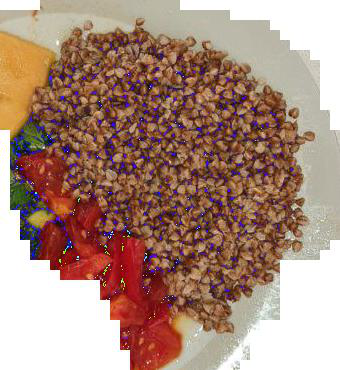

In [34]:
get_image_from_url(urls[5])

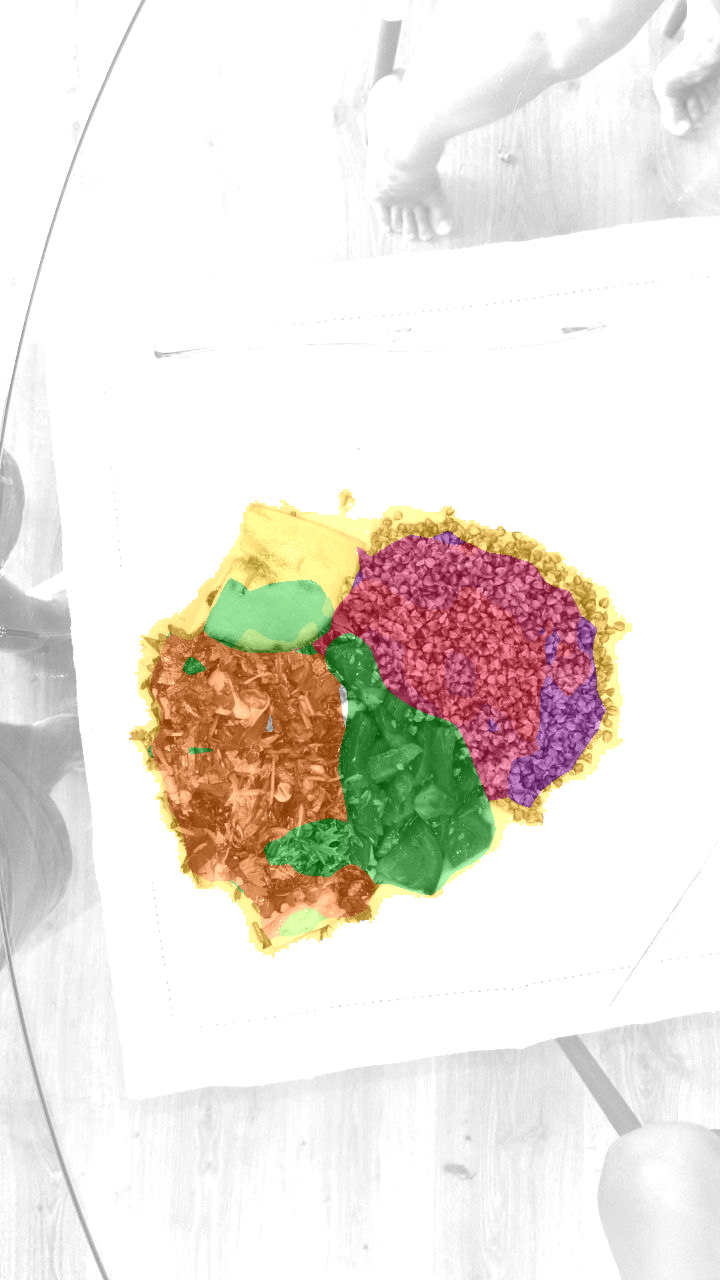

In [24]:
img

In [50]:
img,clip_df,masks,urls,stats

SyntaxError: 'return' outside function (353109122.py, line 36)

In [20]:
img,clip_df,masks,urls,stats = search(url)

/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/dima/anaconda3/envs/f

In [21]:
clip_df

,id,description,category,energy,protein,carb,fat,text,clip,score,classes,area
7,1100553,"Walnuts, excluding honey roasted",Nuts and seeds,654.0,15.23,13.71,65.21,the food is nuts and seeds . it has a little b...,"[0.035385314, 0.008882179, -0.031410024, -0.00...",0.262257,103,76992
8,1100553,"Walnuts, excluding honey roasted",Nuts and seeds,654.0,15.23,13.71,65.21,the food is nuts and seeds . it has a little b...,"[0.035385314, 0.008882179, -0.031410024, -0.00...",0.234819,1,31743
3,1097590,"Yogurt parfait, low fat, with fruit","Yogurt, regular",84.0,3.36,15.86,1.01,"the food is yogurt, regular . it has a little ...","[0.018963907, 0.043753237, 0.018474048, 0.0237...",0.260002,36,19173
0,1102695,"Pomegranate, raw",Other fruits and fruit salads,83.0,1.67,18.70,1.17,the food is other fruits and fruit salads . it...,"[0.030820213, -0.0053939554, -0.0217254, 0.016...",0.259355,10,17439
4,1102693,"Plum, raw",Other fruits and fruit salads,46.0,0.70,11.42,0.28,the food is other fruits and fruit salads . it...,"[0.04782226, -0.0014078125, -0.0021409828, 0.0...",0.254592,44,16946
2,1102693,"Plum, raw",Other fruits and fruit salads,46.0,0.70,11.42,0.28,the food is other fruits and fruit salads . it...,"[0.04782226, -0.0014078125, -0.0021409828, 0.0...",0.255209,29,15753
5,1102626,"Blueberries, dried",Dried fruits,317.0,2.50,80.00,2.50,the food is dried fruits . it has a little bit...,"[0.003976136, 0.005749459, -0.028017472, 0.002...",0.238218,45,9876
1,1101788,Cereal (Barbara's Puffins),"Ready-to-eat cereal, lower sugar (=<21.2g/100g)",333.0,7.41,84.00,3.70,"the food is ready-to-eat cereal, lower sugar (...","[0.0102496175, -5.9109166e-06, 0.011516266, 0....",0.231929,26,7507
6,1102693,"Plum, raw",Other fruits and fruit salads,46.0,0.70,11.42,0.28,the food is other fruits and fruit salads . it...,"[0.04782226, -0.0014078125, -0.0021409828, 0.0...",0.233975,82,2394


In [31]:
!conda activate f4; nbdev_build_lib


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.


/bin/bash: nbdev_build_lib: command not found
